# **Model evaluation for East Africa drought study**

In [1]:
import sys; sys.path.append('/home/clair/wwa')
from wwa import *
from wwa_nonstationary_fitting import *

sf = gpd.read_file("sf_gha")

---
## **CORDEX**

### **Pre-processing**

Data downloaded via synda

**Precip:**
```
for fnm in sorted(glob.glob("../synda/data/CORDEX/AFR-44/*/*/*/day/pr")):
    
    mdl_fl = sorted(glob.glob(fnm+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
    
    # otherwise - carry on
    rcp = xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050"))
    hist = xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm])
    
    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask & larger rectangular mask
    da = xr.concat([hist, rcp], "time").pr
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
                  
    # daily time series over study region (will compute seasonal/annual indices separately)
    ts = convert_units_to(da.where(rm == 1).mean(xy_dims), "mm/day")
    ts.to_netcdf(new_fnm)
                  
    # seasonal cycle over the study region (obs period only)
    sc = ts.sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("sc_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # spatial pattern over larger rectangular region (obs period only)
    sp_mask = np.logical_and(np.logical_and(da.lat > -15, da.lat < 18), np.logical_and(da.lon > 28, da.lon < 54))
    sp = da.where(rm == 1).dropna(xy_dims[0], "all").dropna(xy_dims[1], "all").sel(time = slice("1980", "2022"))
    
    # check spatial patterns for short & long rains separately
    sp.sel(time = [m in [10,11,12] for m in sp.time.dt.month]).mean("time").to_netcdf("sp-ond_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    sp.sel(time = [m in [3,4,5] for m in sp.time.dt.month]).mean("time").to_netcdf("sp-mam_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
```

**Temperature & computed PET:**
```
for fpath in glob.glob("/rds/general/user/cb2714/home/synda/data/CORDEX/AFR-*/*/*/*/day/tas"):
    
    mdl_fl = sorted(glob.glob(fpath+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
        
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
        
    # otherwise - carry on
    rcp = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050")), "default", align_on = "year")
    hist = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm]), "default", align_on = "year")

    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask & larger rectangular mask
    da = convert_units_to(xr.concat([hist, rcp], "time").tas, "degC")
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    # PET averaged over the study region
    pet = convert_units_to(potential_evapotranspiration(tas = da, method = "thornthwaite48"), "mm/day", context = "hydro").rename("pet")
    pet_ts = pet.where(rm == 1).mean(xy_dims)
    pet_ts.to_netcdf(re.sub("tas", "pet", new_fnm))

    # spatial pattern over larger rectangular region (obs period only)
    sp_mask = np.logical_and(np.logical_and(da.lat > -15, da.lat < 18), np.logical_and(da.lon > 28, da.lon < 54))
    sp = da.where(sp_mask == 1).dropna(xy_dims[0], "all").dropna(xy_dims[1], "all").sel(time = slice("1980", "2022"))
    sp.to_netcdf("sp_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
    
    # seasonal cycle over the study region (obs period only)
    sc = da.where(rm == 1).mean(xy_dims).sel(time = slice("1980", "2022")).groupby("time.dayofyear").mean()
    sc.to_netcdf("sc_"+re.sub("[0-9]{8}-[0-9]{8}", "19800101-20221231", new_fnm))
```

**evspsblpot:**
```
for fpath in glob.glob("/rds/general/user/cb2714/home/synda/data/CORDEX/AFR-*/*/*/*/day/evspsblpot"):
    
    mdl_fl = sorted(glob.glob(fpath+"/*.nc"))
    new_fnm = re.sub("_[0-9]{8}-", "_"+mdl_fl[0][-20:-12]+"-", mdl_fl[-1].split("/")[-1])
    print(new_fnm)
    
    # also skip if not both historical & RCP runs available
    if not all([any([s in fnm for fnm in mdl_fl]) for s in ["historical", "rcp85"]]): continue
        
    # skip if file already exists
    if len(glob.glob(new_fnm)) > 0: continue
        
    # otherwise - carry on
    rcp = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "rcp85" in fnm]).sel(time = slice(None, "2050")), "default", align_on = "year")
    hist = convert_calendar(xr.open_mfdataset([fnm for fnm in mdl_fl if "historical" in fnm]), "default", align_on = "year")

    if "rlon" in rcp.dims:
        hist = hist.assign_coords(rlon = rcp.rlon, rlat = rcp.rlat)
        xy_dims = ["rlon", "rlat"]
    elif "x" in rcp.dims:
        hist = hist.assign_coords(x = rcp.x, y = rcp.y)
        xy_dims = ["x", "y"]
    else:
        print(hist.dims)
        continue
    
    # combine historical & rcp into single array, create regionmask
    da = convert_units_to(xr.concat([hist, rcp], "time").evspsblpot, "mm/day", context = "hydro")
    rm = regionmask.mask_3D_geopandas(sf, da.lon, da.lat, drop = False).squeeze(drop = True)
    
    # get daily time series over study region
    ts = da.where(rm == 1).mean(xy_dims)
    ts.to_netcdf(new_fnm)
```

### **Time series for climate explorer**

In [37]:
for fnm in glob.glob("cordex/pr_*.nc"):
    
    ds = convert_calendar(xr.open_dataset(fnm).pr.resample(time = "MS").sum(), "default", align_on = "date")
    mdl = cordex_model(fnm)
     
    for season in ["mam", "ond", "24"]:
        
        s_string = {"mam" : "MAM", "ond" : "OND", "24" : "24m accumulated"}[season]
        s_str2 = {"mam" : "MAM", "ond" : "OND", "24" : "2-year"}[season]
        
        csv_fnm = "ts/EA-drought_pr-"+season+"_"+fnm.split("_")[1]+"_"+cordex_model(fnm)+".dat"
        if len(csv_fnm) >= 65: print("! Filename too long: ", csv_fnm)
        
        # create  header lines
        str1 = "# contact :: CORDEX "+re.sub("_day.+", "", re.sub(".+pr_", "", fnm))+" "+s_string+" precip - East Africa drought 2023, c.barnes22@imperial.ac.uk"
        str2 = "# pr_"+season+" [mm] "+s_str2+" accumulated precipitation at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
        head = "# year pr_"+season
        
        ! echo "$str1 " > $csv_fnm
        ! echo "$str2" >> $csv_fnm
        ! echo "$head" >> $csv_fnm
        
        # get 3-month accumulated precip
        if season == "mam":
            pr = ds.rolling(time = 3).sum().groupby("time.month")[5]
        elif season == "ond":
            pr = ds.rolling(time = 3).sum().groupby("time.month")[12]
        elif season == "24":
            pr = ds.rolling(time = 24).sum().groupby("time.month")[12]
        
        pr.assign_coords(time = pr.time.dt.year).dropna("time", "any").to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

#### **GMST & Nino**

In [69]:
# Copy CMIP5 GMST files across
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/pr_*.nc")])):
    
    gsat_fnm = glob.glob("../00_gsat/*"+gcm+"*.dat")
    
    if len(gsat_fnm) == 0:
        print("No GSAT:", gcm)
        continue

    gsat_fnm = gsat_fnm[0]
    new_fnm = "ts/EA-drought_"+re.sub(".+Amon", "gsat", gsat_fnm)
    if len(new_fnm.split("/")[-1]) > 65: print("Filename too long:", new_fnm)
    
    ! cp $gsat_fnm $new_fnm

No GSAT: IPSL-CM5A-MR_rcp85_r1
No GSAT: MPI-ESM-LR_rcp85_r3
No GSAT: GFDL-ESM2M_rcp85_r1
No GSAT: MPI-ESM-LR_rcp85_r2


In [71]:
for gcm in list(set(["_rcp85_".join(cordex_model(fnm).split("_")[:2]) for fnm in glob.glob("cordex/pr_*.nc")])):
    
    nino_fnm = glob.glob("../10_nino-detrended/*"+gcm+"*.nc")
    
    if len(nino_fnm) == 0:
        print("No Nino:", gcm)
        continue
        
    nino_fnm = nino_fnm[0]
    nino_ond = xr.open_dataset(nino_fnm).nino34_dt.rolling(time = 3, center = False).mean().groupby("time.month")[12]
    nino_ond = nino_ond.assign_coords(time = nino_ond.time.dt.year).dropna("time", "any")
    
    # filename & headers for CSV
    csv_fnm = "ts/EA-drought_detrended-nino-ond_"+gcm+".dat"
    if len(csv_fnm.split("/")[-1]) > 65: print("Filename too long:", csv_fnm)
    
    str1 = "# contact :: CMIP5 mean detrended Nino3.4 index for OND - East Africa drought 2023, c.barnes22@imperial.ac.uk"
    str2 = "# nino34 [degC] Nino3.4 index detrended with Indian Ocean tropical SSTs from CVDP at "+re.sub(".dat", "", csv_fnm.split("/")[-1])
    head = "# year nino34"

    ! echo "$str1 " > $csv_fnm
    ! echo "$str2" >> $csv_fnm
    ! echo "$head" >> $csv_fnm
    
    nino_ond.to_dataframe().to_csv(csv_fnm, sep = " ", mode = "a", header = False)

No Nino: IPSL-CM5A-MR_rcp85_r1
No Nino: MPI-ESM-LR_rcp85_r3
No Nino: GFDL-ESM2M_rcp85_r1
No Nino: EC-EARTH_rcp85_r3
No Nino: EC-EARTH_rcp85_r12
No Nino: MPI-ESM-LR_rcp85_r2
No Nino: EC-EARTH_rcp85_r1


### **Spatial patterns**

In [12]:
chirps = decode_times(xr.open_dataset("data/centrends_chirps_28-54E_-15-18N.nc", decode_times = False)).precip.dropna("time", "all")
chirps = chirps.where(np.isnan(chirps).sum("time") == 0)

In [15]:
pr3_cpc = xr.open_dataset("data/cpc_pr_monthly.nc").precip.rolling(time = 3).mean().groupby("time.month")

cpc_mam, cpc_ond = [xr.open_dataset("data/cpc_pr-"+seas+"-spatial.nc").precip.mean("time") for seas in ["mam", "ond"]]
chirps_mam, chirps_ond = [chirps.rolling(time = 3).mean().sel(time = slice("1979", "2022")).groupby("time.month")[m].mean("time") for m in [5,12]]

#### **MAM precip**

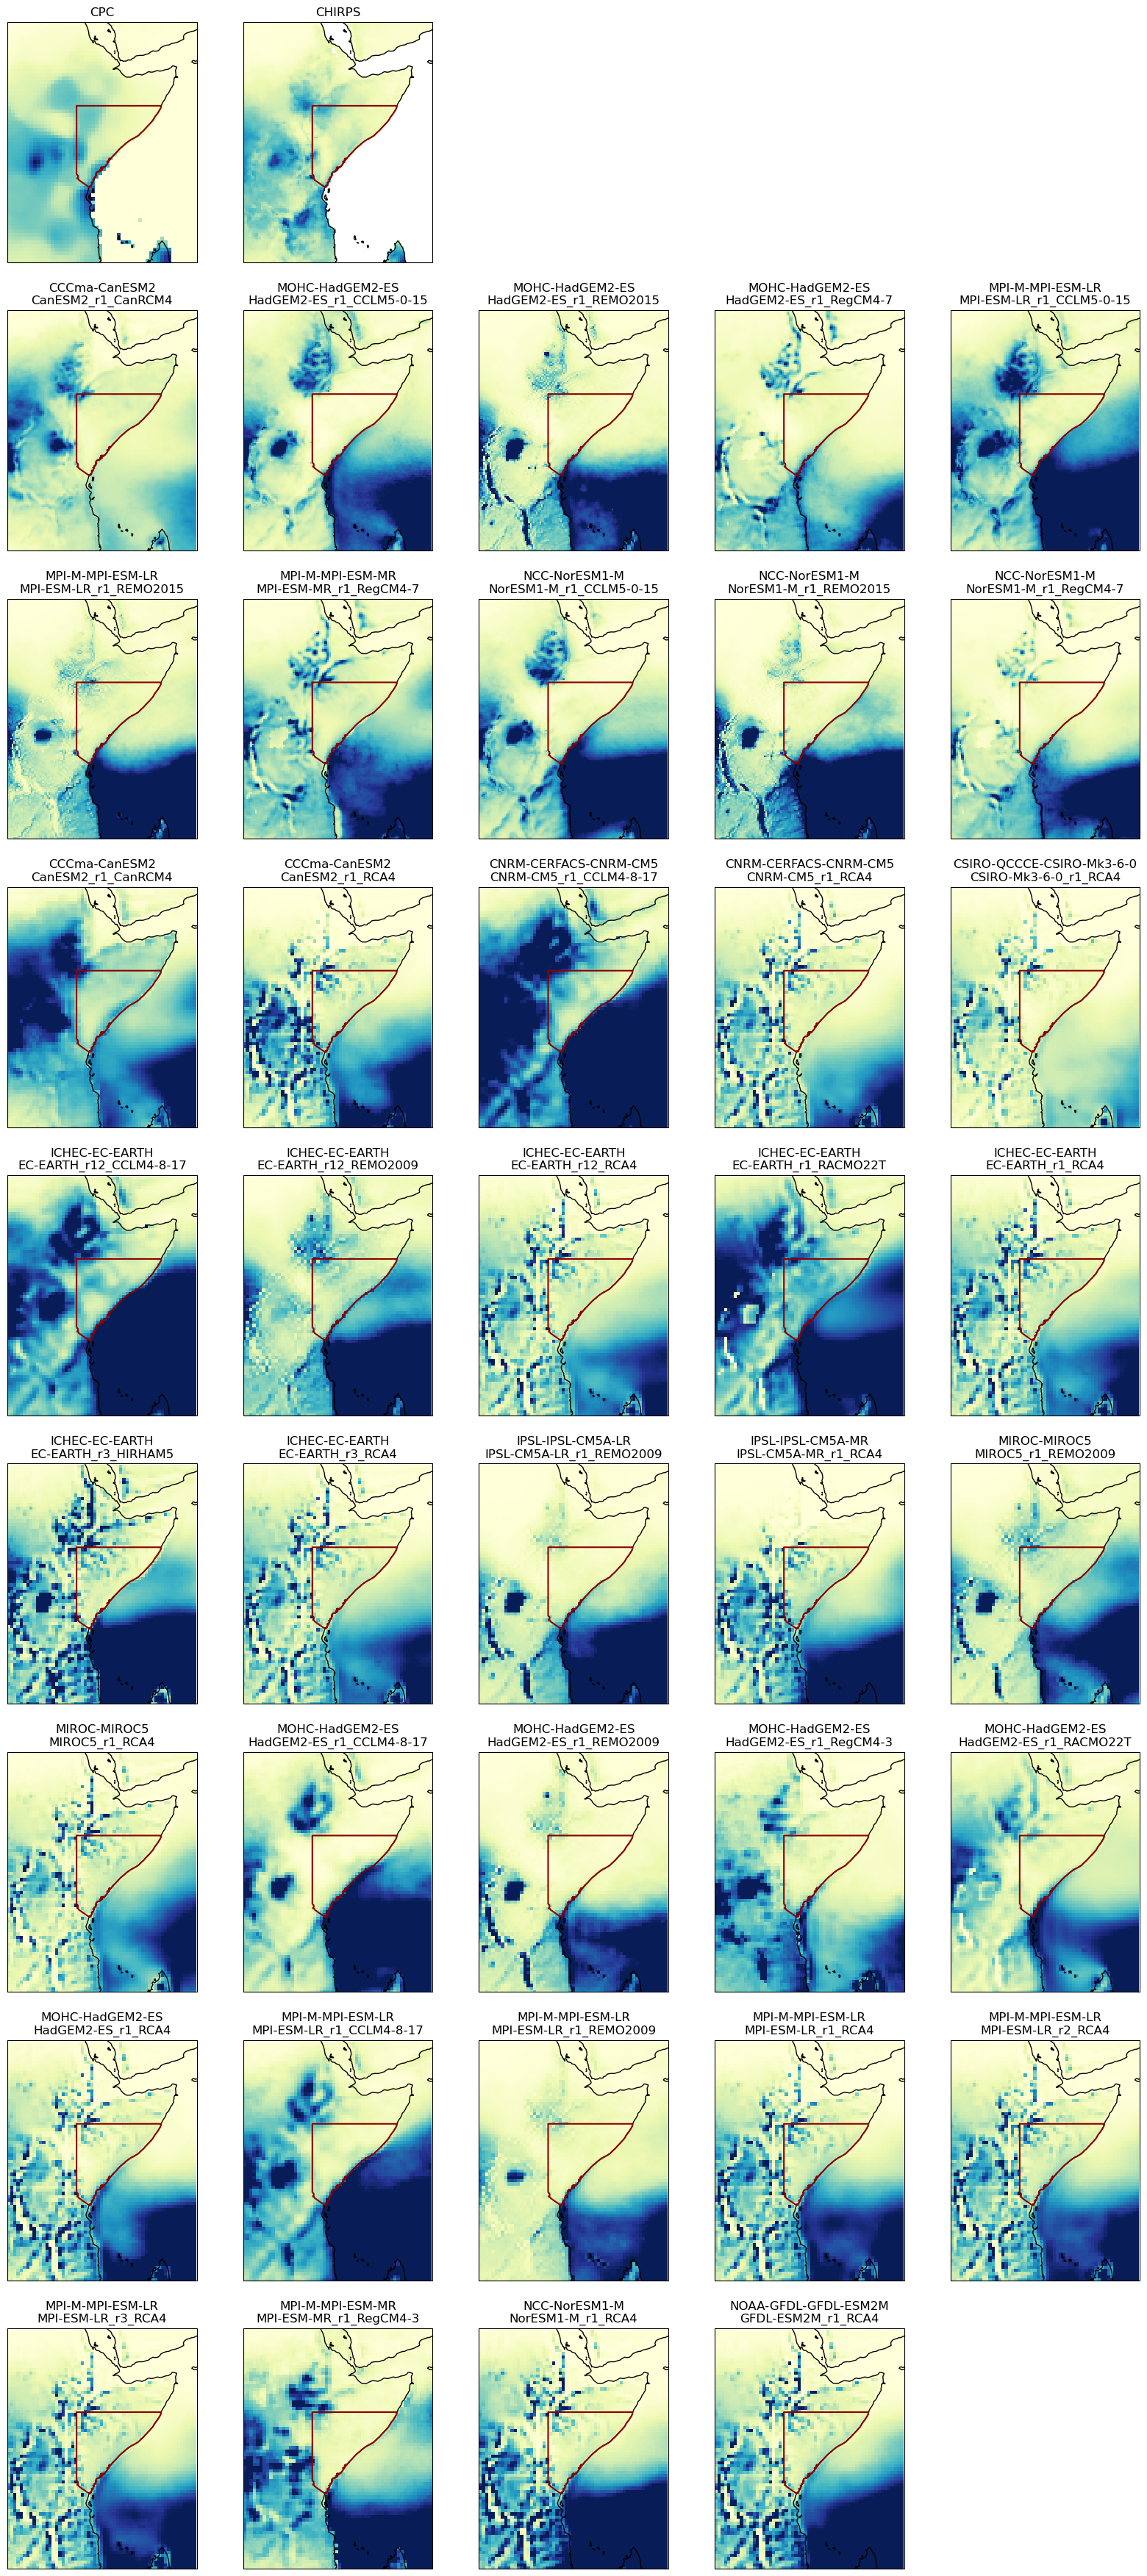

In [50]:
fl = sorted(glob.glob("cordex/sp-mam-pr_*.nc"))
nc = 5

nr = int(np.ceil(len(fl) / nc)+1)
plot_kws = {"cmap" : "YlGnBu", "vmin" : 0}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*5), dpi = 100,
                        subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28,54,-15,18)})
# plt.subplots_adjust(wspace = 0.01)

# reference patterns from observations
cpc_mam.assign_attrs(long_name = "Precip").plot(ax = axs[0,0], add_colorbar = False, **plot_kws)
axs[0,0].set_title("CPC")
chirps_mam.assign_attrs(long_name = "Precip").plot(ax = axs[0,1], add_colorbar = False, **plot_kws) 
axs[0,1].set_title("CHIRPS")

# turn off remaining axes in top row
for ax in axs[0,:2]: 
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
for ax in axs[0,2:]: ax.set_axis_off()

# plot individual runs

for i in range(len(fl)):
    
    fnm = fl[i]
    pr_sp = convert_units_to(xr.open_dataset(fnm).pr, "mm/month")
    pr_max = pr_sp.where(regionmask.mask_3D_geopandas(sf, pr_sp.lon, pr_sp.lat, drop = False).squeeze(drop = True) == 1).max()
    
    ax = fig.axes[i+nc]
    cbar = ax.pcolormesh(pr_sp.lon, pr_sp.lat, pr_sp, **plot_kws, vmax = pr_max)
    ax.set_title(fnm.split("_")[2]+"\n"+cordex_model(fnm[14:]))
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
if len(fl) < ((nr-1) * nc):
    for ax in fig.axes[len(fl)+nc:]: ax.set_axis_off()
    
plt.savefig("fig/cordex_spatial_pr-mam.png")

#### **OND precip**

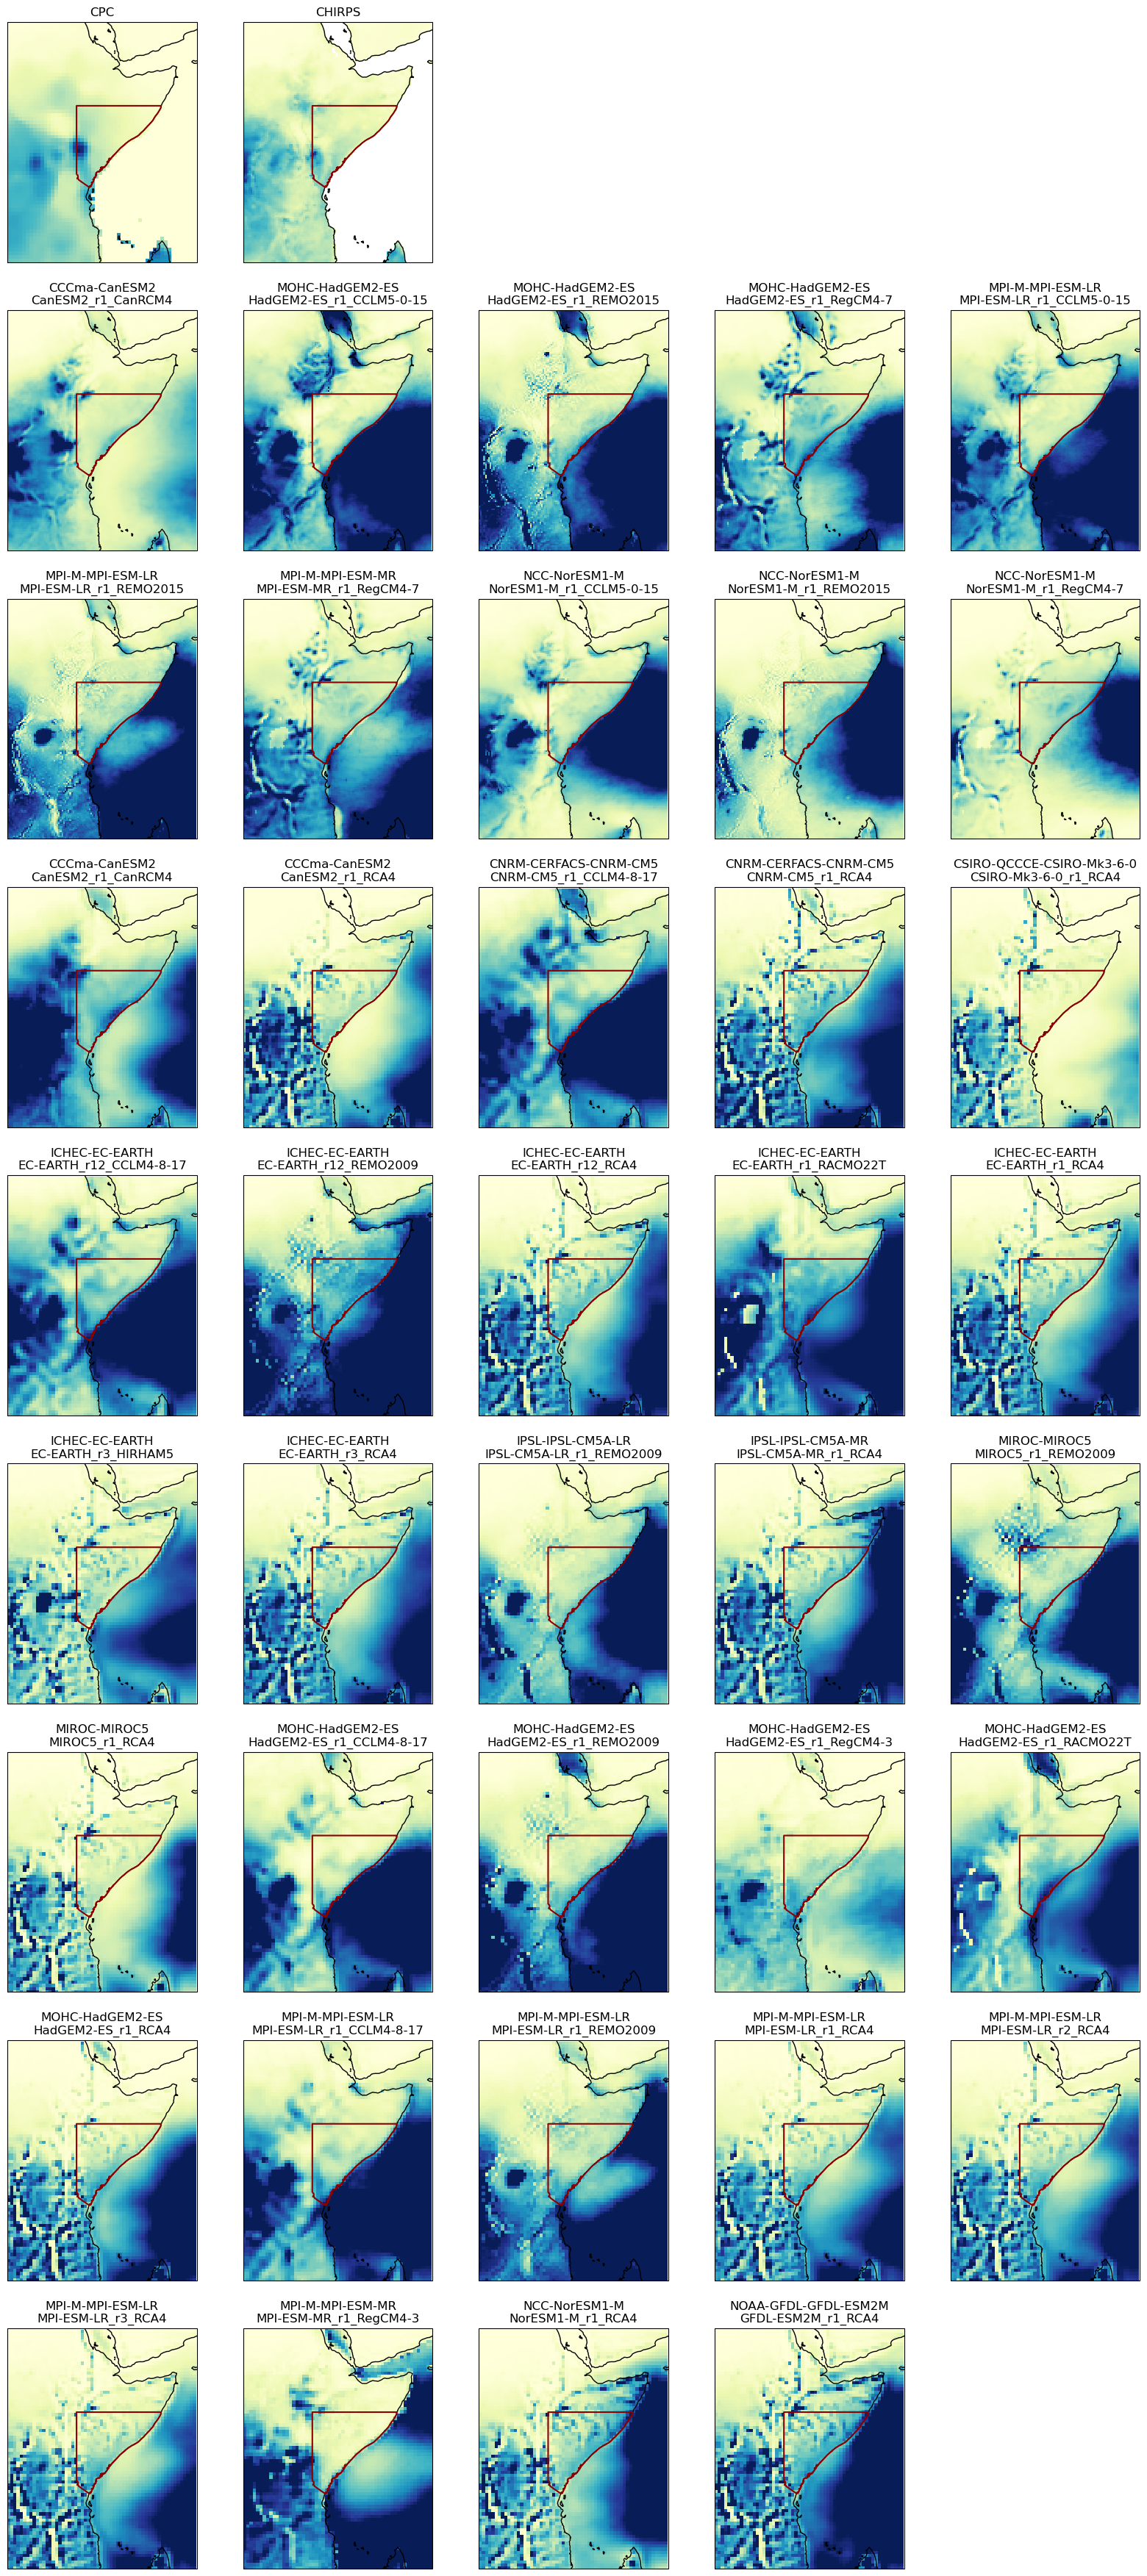

In [51]:
fl = sorted(glob.glob("cordex/sp-ond-pr_*.nc"))
nc = 5

nr = int(np.ceil(len(fl) / nc)+1)
plot_kws = {"cmap" : "YlGnBu"}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*5), dpi = 100,
                        subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28,54,-15,18)})
# plt.subplots_adjust(wspace = 0.01)

# reference patterns from observations
cpc_ond.assign_attrs(long_name = "Precip").plot(ax = axs[0,0], add_colorbar = False, **plot_kws)
axs[0,0].set_title("CPC")
chirps_ond.assign_attrs(long_name = "Precip").plot(ax = axs[0,1], add_colorbar = False, **plot_kws) 
axs[0,1].set_title("CHIRPS")

# turn off remaining axes in top row
for ax in axs[0,:2]: 
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
for ax in axs[0,2:]: ax.set_axis_off()

# plot individual runs

for i in range(len(fl)):
    
    fnm = fl[i]
    pr_sp = convert_units_to(xr.open_dataset(fnm).pr, "mm/month")
    pr_max = pr_sp.where(regionmask.mask_3D_geopandas(sf, pr_sp.lon, pr_sp.lat, drop = False).squeeze(drop = True) == 1).max()

    ax = fig.axes[i+nc]
    cbar = ax.pcolormesh(pr_sp.lon, pr_sp.lat, pr_sp, **plot_kws, vmax = pr_max)
    ax.set_title(fnm.split("_")[2]+"\n"+cordex_model(fnm[14:]))
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
if len(fl) < ((nr-1) * nc):
    for ax in fig.axes[len(fl)+nc:]: ax.set_axis_off()

plt.savefig("fig/cordex_spatial_pr-ond.png")

#### **Annual temperatures**

In [58]:
cpc_tas = xr.open_dataset("data/cpc_tas-spatial.nc").tas

In [61]:
fl

['cordex/sp-tas_AFR-22_CCCma-CanESM2_rcp85_r1i1p1_CCCma-CanRCM4_r2_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_CLMcom-KIT-CCLM5-0-15_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MOHC-HadGEM2-ES_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_CLMcom-KIT-CCLM5-0-15_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MPI-M-MPI-ESM-LR_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_MPI-M-MPI-ESM-MR_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_CLMcom-KIT-CCLM5-0-15_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_GERICS-REMO2015_v1_day_19800101-20221231.nc',
 'cordex/sp-tas_AFR-22_NCC-NorESM1-M_rcp85_r1i1p1_ICTP-RegCM4-7_v0_day_19800101-20221231.nc',
 'cordex/sp-tas

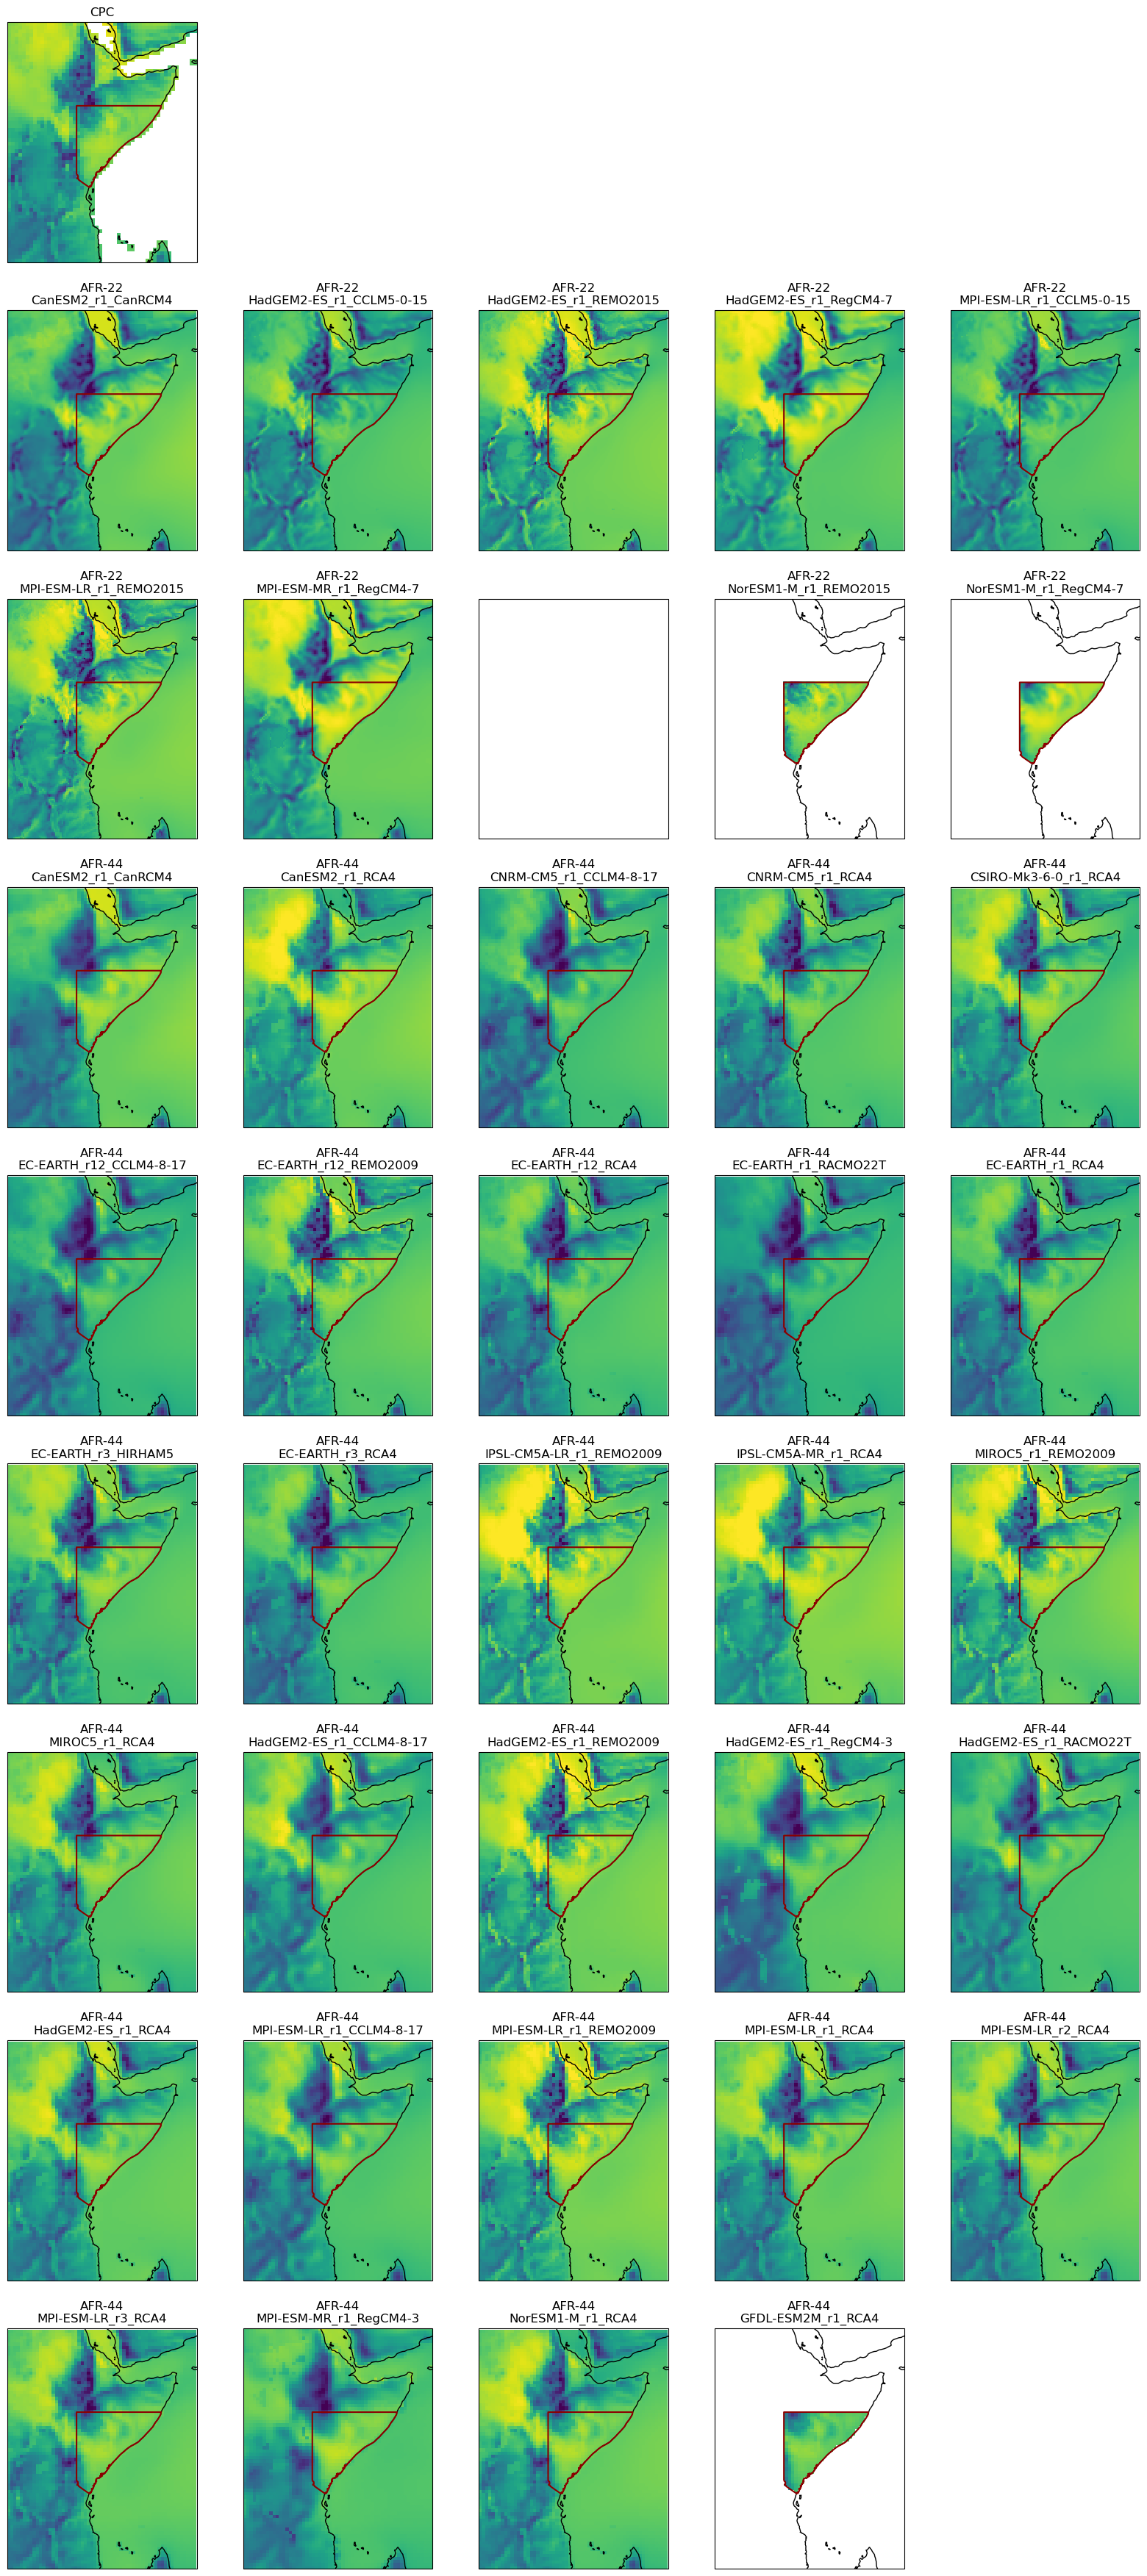

In [65]:
fl = sorted(glob.glob("cordex/sp-tas_*.nc"))
nc = 5

nr = int(np.ceil(len(fl) / nc)+1)
plot_kws = {"cmap" : "viridis", "vmin" : 13, "vmax" : 31}

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*5), dpi = 100,
                        subplot_kw = {"projection" : cartopy.crs.PlateCarree(), "extent" : (28,54,-15,18)})
# plt.subplots_adjust(wspace = 0.01)

# reference patterns from observations
cpc_tas.plot(ax = axs[0,0], add_colorbar = False, **plot_kws)
axs[0,0].set_title("CPC")
axs[0,0].coastlines()
sf.boundary.plot(ax = axs[0,0], color = "darkred")

# turn off remaining axes in top row
for ax in axs[0,1:]: ax.set_axis_off()

# plot individual runs

for i in range(len(fl)):
    
    fnm = fl[i]
    tas_sp = xr.open_dataset(fnm)
    if not "tas" in tas_sp.data_vars: continue
        
    tas_sp = tas_sp.tas
    
    ax = fig.axes[i+nc]
    cbar = ax.pcolormesh(tas_sp.lon, tas_sp.lat, tas_sp, **plot_kws)
    ax.set_title(fnm.split("_")[1]+"\n"+cordex_model(fnm[10:]))
    ax.coastlines()
    sf.boundary.plot(ax = ax, color = "darkred")
    
if len(fl) < ((nr-1) * nc):
    for ax in fig.axes[len(fl)+nc:]: ax.set_axis_off()
        
# plt.savefig("fig/cordex_spatial_tas.png")

### **Seasonal cycle**

In [30]:
cpc_pr = xr.open_dataset("data/cpc_pr_ts-daily.nc").precip.groupby("time.dayofyear").mean()

chirps_pr = xr.open_dataset("data/chirps_pr_ts-daily.nc").precip.groupby("time.dayofyear").mean()

def scale(ts): return((ts - ts.mean()) / ts.std())

from matplotlib.patches import Rectangle

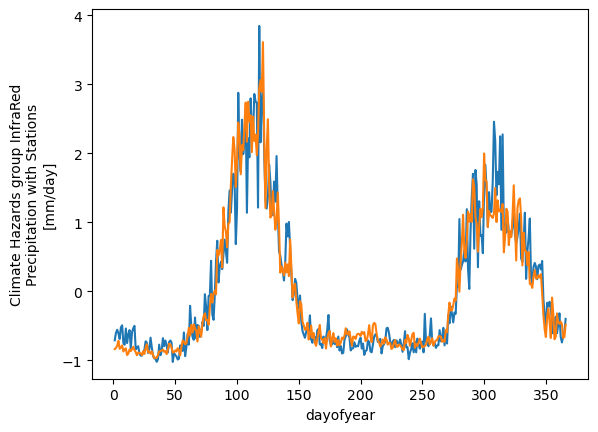

In [46]:
# chirps & CPC almost identical: will use CPC only from now on, to avoid cluttering plots
scale(cpc_pr).plot()
scale(chirps_pr).plot()

#### **Precip**


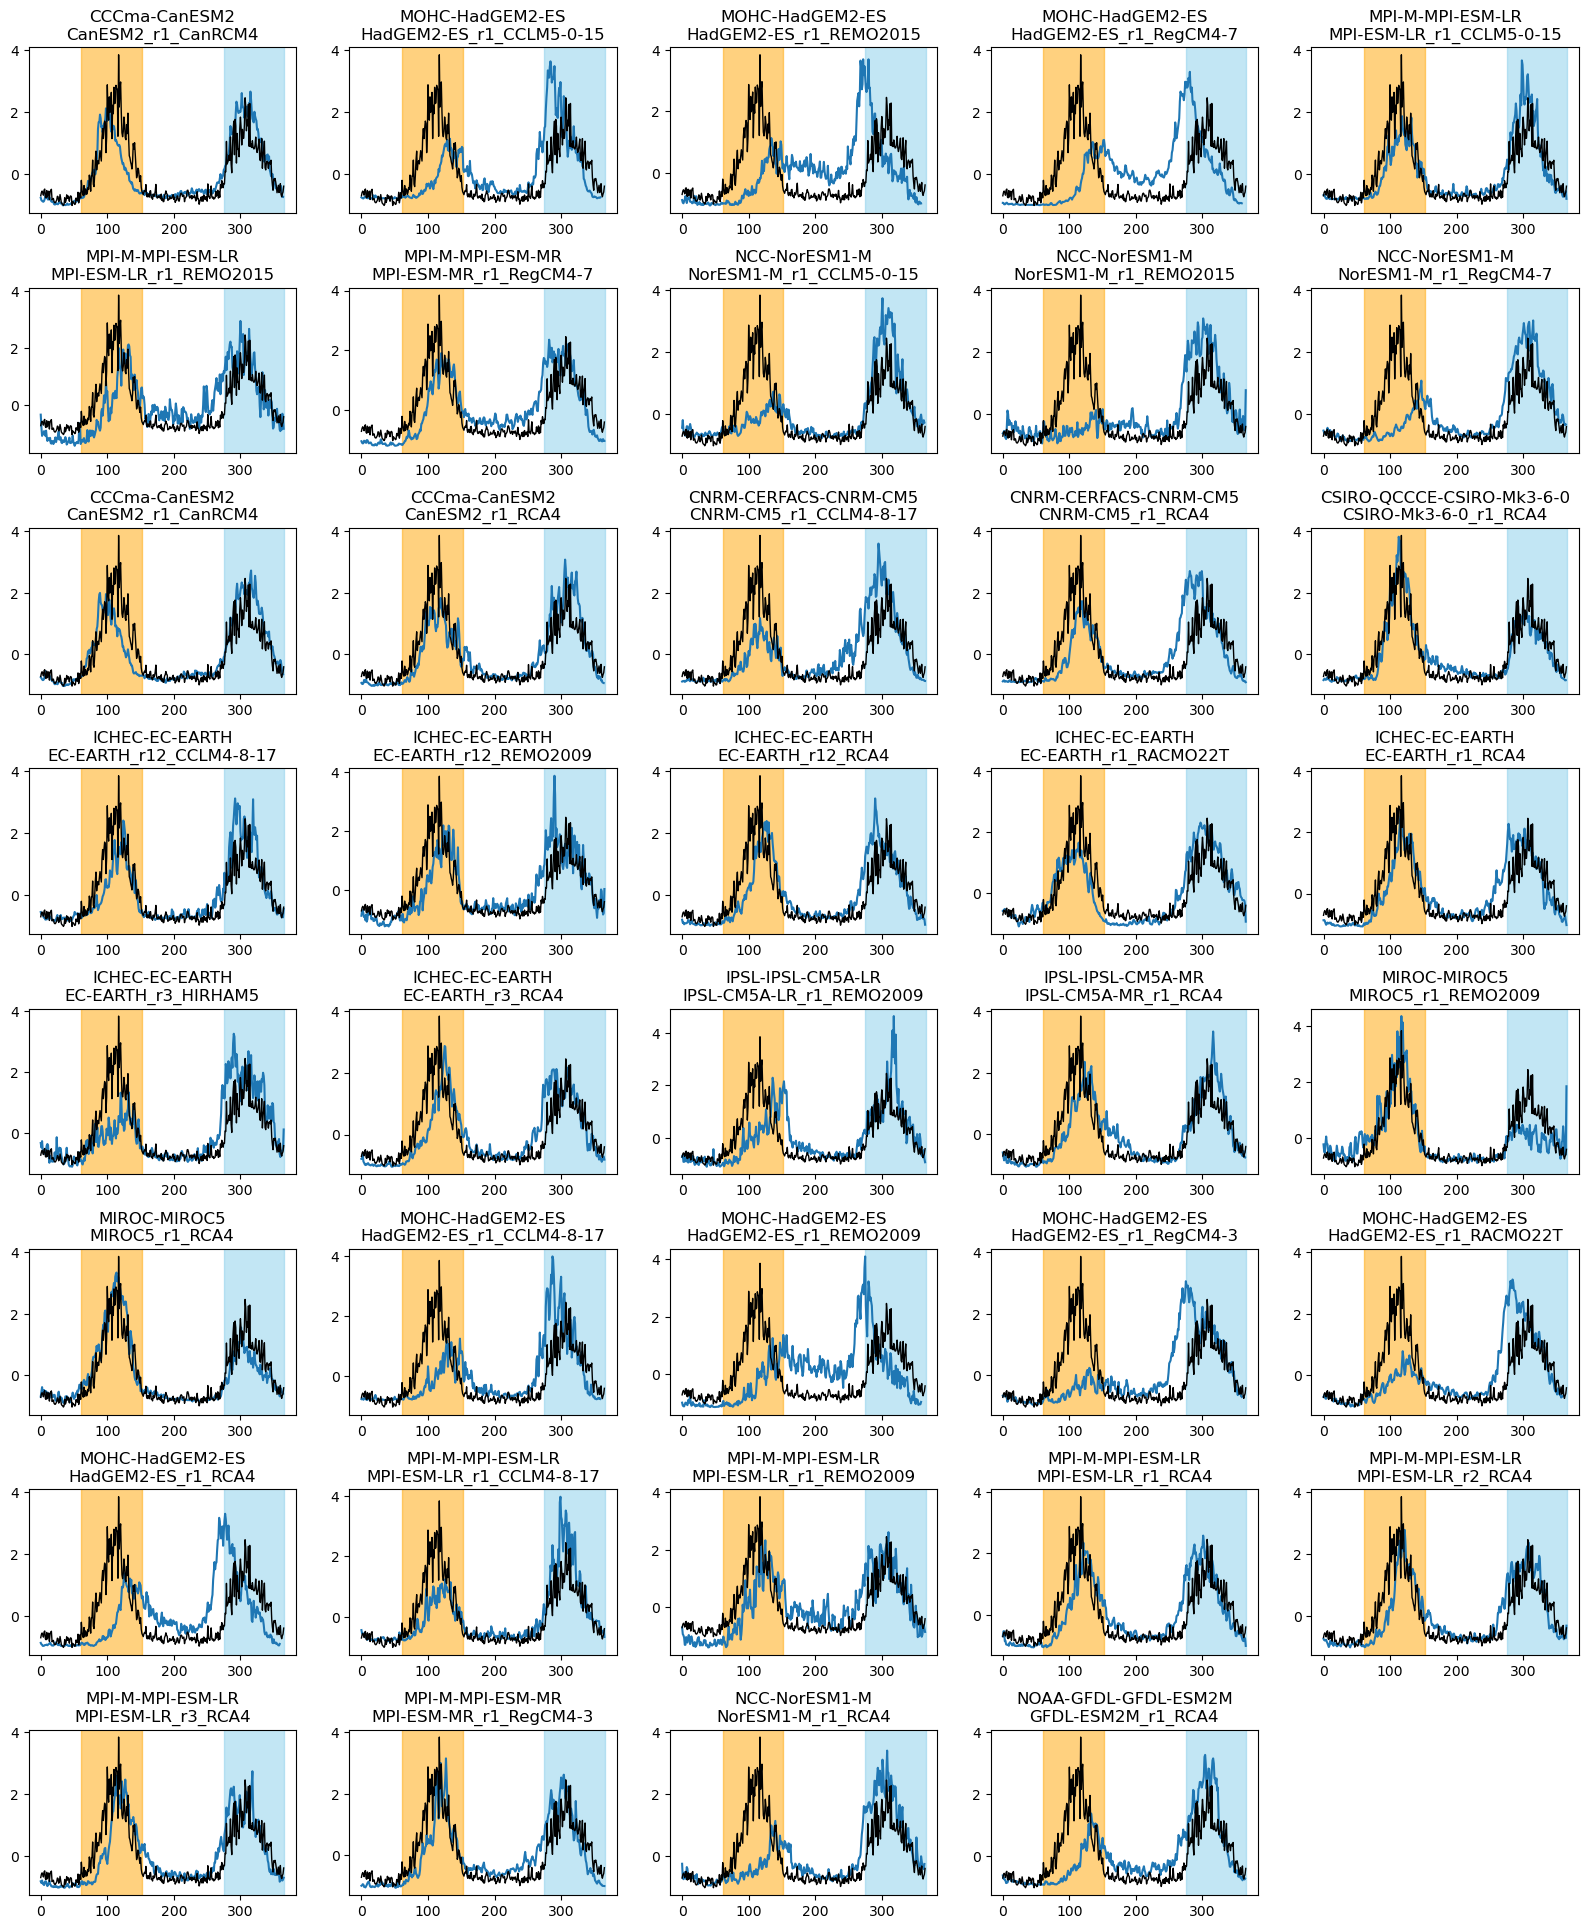

In [66]:
fl = sorted(glob.glob("cordex/sc-pr_*.nc"))

nc = 5

nr = int(np.ceil(len(fl) / nc))

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.45)

for i in range(len(fl)):
    
    fnm = fl[i]
    pr_sc = xr.open_dataset(fl[i]).pr
    
    ax = fig.axes[i]
    ax.plot(scale(pr_sc))
    ax.plot(scale(cpc_pr), color = "k", lw = 1)
    ax.set_title(fnm.split("_")[2]+"\n"+cordex_model(fnm[11:]))
    
    # highlight the short & long rains thar we're interested in
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((datetime(2020,3,1).timetuple().tm_yday, -2), width = 91, height = 10, color = "orange", alpha = 0.5))
    ax.add_patch(Rectangle((datetime(2020,10,1).timetuple().tm_yday, -2), width = 91, height = 10, color = "skyblue", alpha = 0.5))
    ax.set_ylim(ylim)
    
if len(fl) < (nr * nc):
    for ax in fig.axes[len(fl):]: ax.set_axis_off()
    
plt.savefig("fig/cordex_seasonal_pr.png")

#### **Temperatures**


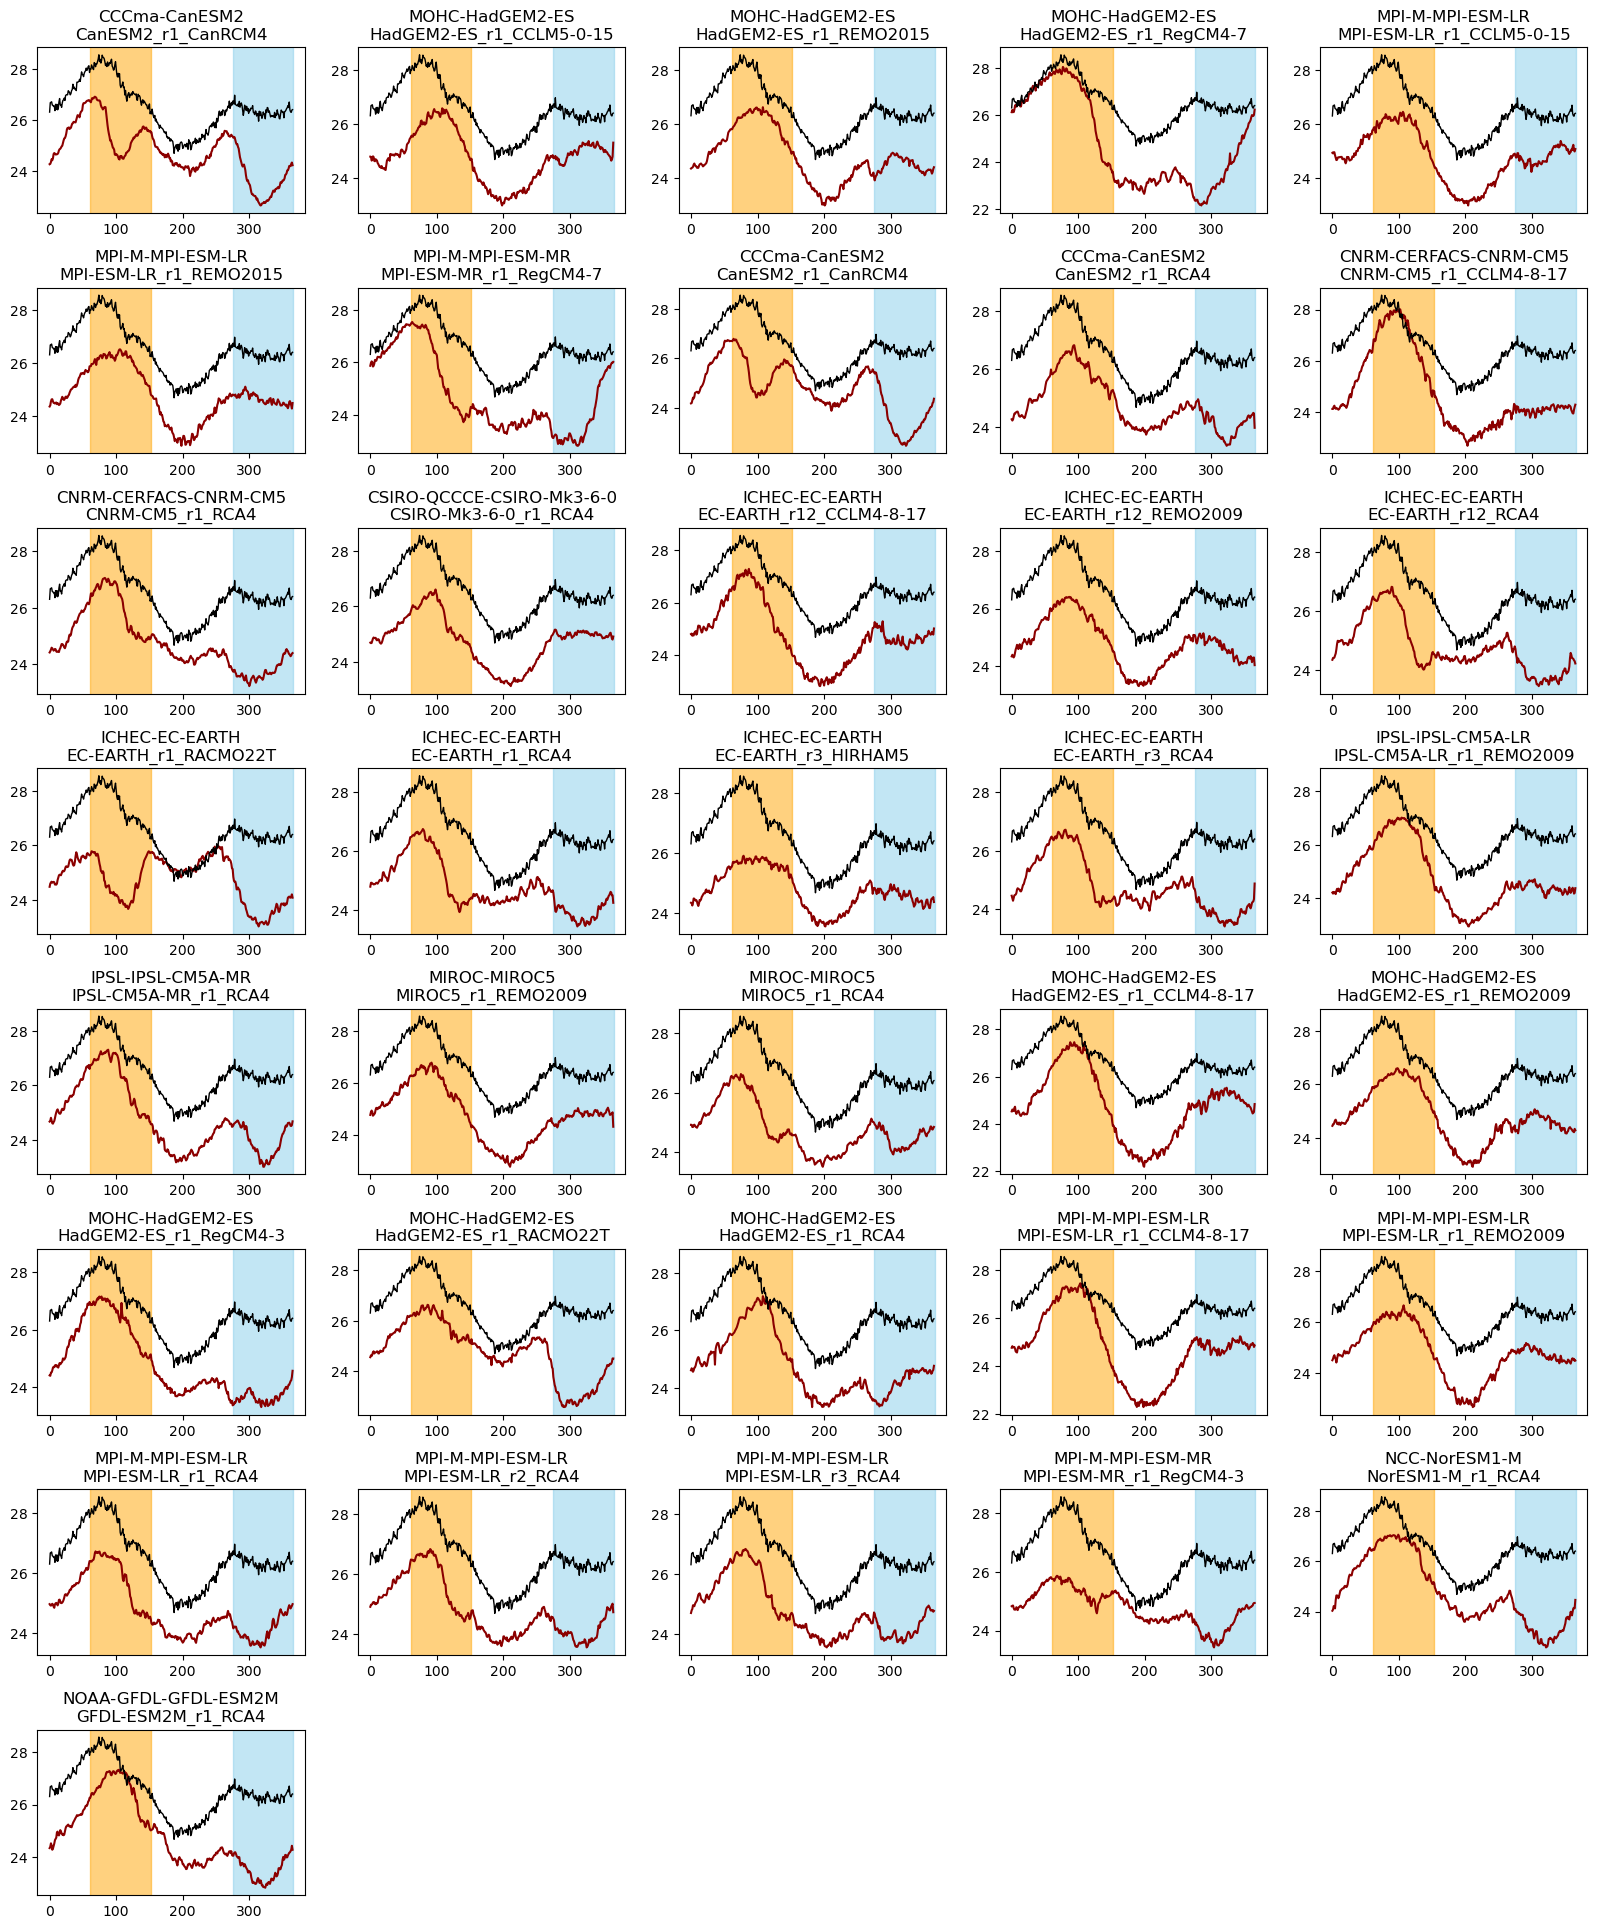

In [67]:
cpc_tas_sc = xr.open_dataset("data/cpc_tas_ts-daily.nc").tas.groupby("time.dayofyear").mean()
cpc_mean = cpc_tas.mean()

fl = sorted(glob.glob("cordex/sc-tas_*.nc"))
nc = 5
nr = int(np.ceil(len(fl) / nc))

fig, axs = plt.subplots(ncols = nc, nrows = nr, figsize = (nc*4,nr*3), dpi = 100)
plt.subplots_adjust(hspace = 0.45)

for i in range(len(fl)):
    
    fnm = fl[i]
    tas_sc= xr.open_dataset(fl[i]).tas
    
    ax = fig.axes[i]
    ax.plot(tas_sc - tas_sc.mean() + cpc_mean, color = "darkred")     # shift to same level, since constant offset is irrelevant
    ax.plot(cpc_tas_sc, color = "k", lw = 1)
    ax.set_title(fnm.split("_")[2]+"\n"+cordex_model(fnm[11:]))
    
    # highlight the short & long rains that we're interested in
    ylim = ax.get_ylim()
    ax.add_patch(Rectangle((datetime(2020,3,1).timetuple().tm_yday, 20), width = 91, height = 10, color = "orange", alpha = 0.5))
    ax.add_patch(Rectangle((datetime(2020,10,1).timetuple().tm_yday, 20), width = 91, height = 10, color = "skyblue", alpha = 0.5))
    ax.set_ylim(ylim)
    
if len(fl) < (nr * nc):
    for ax in fig.axes[len(fl):]: ax.set_axis_off()
    
plt.savefig("fig/cordex_seasonal_tas.png")